<a href="https://colab.research.google.com/github/jzambrano-xyz/ArtificialNeuralNetworks/blob/main/Clasificaci%C3%B3n_con_una_RNA_densa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificación con una RNA densa

Librerías

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk(''):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Librerías para manejo de datos

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import seaborn as sns
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.utils import to_categorical

Datos

In [ ]:
dnndstrain=pd.read_csv('train.csv')
dnndstest=pd.read_csv('test.csv')

Análisis de datos

In [ ]:
dnndstrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11692 entries, 0 to 11691
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       11692 non-null  float64
 1   1       11692 non-null  float64
 2   2       11692 non-null  float64
 3   3       11692 non-null  float64
 4   4       11692 non-null  float64
 5   5       11692 non-null  float64
 6   6       11692 non-null  float64
 7   7       11692 non-null  float64
 8   8       11692 non-null  float64
 9   9       11691 non-null  float64
 10  10      11691 non-null  float64
 11  11      11691 non-null  float64
 12  12      11691 non-null  float64
 13  13      11691 non-null  float64
 14  14      11691 non-null  float64
 15  15      11691 non-null  float64
 16  16      11691 non-null  float64
 17  17      11691 non-null  float64
 18  18      11691 non-null  float64
 19  19      11691 non-null  float64
 20  20      11691 non-null  float64
 21  21      11691 non-null  float64
 22

In [ ]:
dnndstrain.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,label
count,11692.000000,11692.000000,11692.000000,11692.000000,11692.000000,11692.000000,11692.000000,11692.000000,11692.000000,11691.000000,11691.000000,11691.000000,11691.000000,11691.000000,11691.000000,11691.000000,11691.000000,11691.000000,11691.000000,11691.000000,11691.000000,11691.000000,11691.000000,11691.000000,11691.000000,11691.000000,11691.000000,11691.000000,11691.000000,11691.000000,11691.000000
mean,-44.924108,48.805083,81.412007,58.052431,-704.463777,-597.346577,-705.397546,2.383316,19.026052,158.746017,1.432021,-0.115009,-705.084476,39.024284,-0.024274,-0.014044,46.524729,-0.030140,0.053760,41.525093,0.004300,210.598302,0.984176,-346.569473,-397.525139,-397.513302,-688.243158,-705.238256,-705.232373,73.197006,0.351210
std,402.774595,35.216182,39.853124,63.185353,456.297458,656.438851,454.853993,0.783654,21.460925,114.808516,0.835828,1.195201,455.401163,23.761844,1.220084,1.816300,21.432180,1.273114,1.823279,31.829820,1.820981,125.312207,0.977684,532.427732,488.992454,489.002131,481.781550,455.164148,455.173024,96.616242,0.477369
min,-999.000000,0.009000,10.052000,0.000000,-999.000000,-999.000000,-999.000000,0.300000,0.000000,46.470000,0.047000,-1.414000,-999.000000,20.000000,-2.493000,-3.140000,26.002000,-2.475000,-3.141000,0.450000,-3.140000,17.931000,0.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,0.000000,0.000000
25%,79.441000,18.761750,59.831500,14.769500,-999.000000,-999.000000,-999.000000,1.815000,2.898750,77.521500,0.881000,-1.369000,-999.000000,24.752000,-0.952000,-1.567500,32.346000,-1.014500,-1.512000,21.251500,-1.567500,124.250000,0.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,0.000000,0.000000
50%,105.840000,45.864500,73.982000,38.253500,-999.000000,-999.000000,-999.000000,2.504500,12.466500,120.579000,1.279000,-0.290000,-999.000000,31.793000,-0.031000,-0.059000,40.453000,-0.080000,0.100000,34.578000,-0.009000,180.145000,1.000000,38.809000,-1.861000,-2.052000,-999.000000,-999.000000,-999.000000,40.359000,0.000000
75%,130.929250,73.339250,92.361250,79.144750,0.488250,84.575250,-4.280750,2.965000,27.608000,203.914000,1.763000,1.230000,0.000000,44.985500,0.898000,1.546000,53.331500,0.956500,1.648000,51.961500,1.575500,264.899500,2.000000,75.989500,0.409500,0.518500,34.039000,-2.373500,-2.247500,112.443500,1.000000
max,923.613000,542.328000,514.429000,590.895000,7.680000,2856.357000,14.324000,5.452000,234.461000,1282.523000,10.703000,1.414000,1.000000,622.862000,2.479000,3.141000,307.823000,2.490000,3.140000,458.884000,3.142000,1364.632000,3.000000,681.232000,4.440000,3.141000,358.701000,4.350000,3.139000,1039.932000,1.000000


Correlación

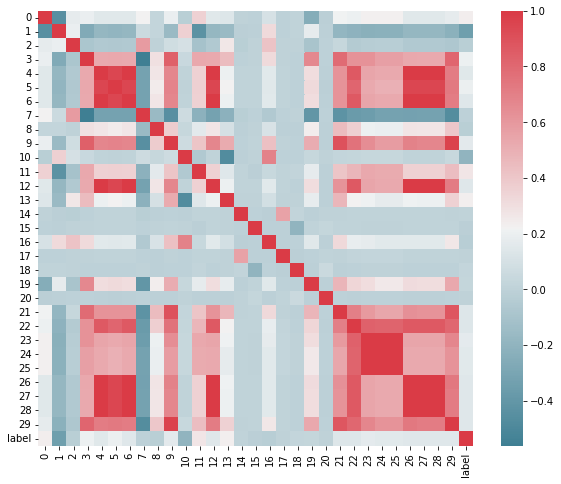

In [ ]:
f, ax = plt.subplots(figsize=(10, 8))
corr = dnndstrain.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

Selección de datos útiles

In [ ]:
# feature selection
def select_features(X_train, y_train, X_test):
    # configure to select all features
    fs = SelectKBest(score_func=f_classif, k='all')
    # learn relationship from training data
    fs.fit(X_train, y_train)
    # transform train input data
    X_train_fs = fs.transform(X_train)
    # transform test input data
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

In [ ]:
dnndstrain.label.value_counts()

0.0    7585
1.0    4106
Name: label, dtype: int64

In [ ]:
X_train = dnndstrain

In [ ]:
y_train = X_train.pop('label')

In [ ]:
X_test = dnndstest

Visualización de datos

In [ ]:
# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)
# what are scores for the features
for i in range(len(fs.scores_)):
    print('Feature %d: %f' % (i, fs.scores_[i]))
# plot the scores
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

ValueError: ignored

Limpieza de valores no importantes (columnas)

In [ ]:
dropFeatures=['2','7','8','14','15','16','17','18','19']

In [ ]:
X_train.drop(dropFeatures,axis=1,inplace=True)

In [ ]:
X_test.drop(dropFeatures,axis=1,inplace=True)

Escalado de datos para tener valores en el mismo rango

In [ ]:
mmscaler = MinMaxScaler()

In [ ]:
X_train = mmscaler.fit_transform(X_train)

In [ ]:
seed = 1000
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.8,
                                                  random_state=seed)

In [ ]:
X_test = mmscaler.fit_transform(X_test)

Desarrollo del modelo

In [ ]:
# Creating a Sequential Model and adding the layers
model = Sequential()
model.add(tf.keras.Input(shape=(21,)))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(Dense(2,activation=tf.nn.softmax))
model.output_shape

Optimización con Adam

In [ ]:
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=90000,
    decay_rate=0.8,
    staircase=True)

opt = tf.keras.optimizers.Adam(
    learning_rate=lr_schedule,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name="Adam",
)

Entrenamiento (100 épocas)

In [ ]:
nepochs = 100
model.compile(optimizer=opt, 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])
history = model.fit(x=X_train, y=y_train, epochs=nepochs, batch_size=4, validation_data=(X_val,y_val))

Análisis de desempeño del entrenamiento

In [ ]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [ ]:
plot_history(history)

Análisis por Matriz de confusión

In [ ]:
yhat = model.predict(X_val)
yhatm = np.argmax(yhat,axis=1)
cm = confusion_matrix(y_val, np.rint(yhatm))

In [ ]:
df_cm = pd.DataFrame(cm, columns=np.unique(y_val), index = np.unique(y_val))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True, fmt='d', annot_kws={"size": 16})# font size

Error

In [ ]:
rights = df_cm.iloc[0,0] + df_cm.iloc[1,1]
wrongs = df_cm.iloc[0,1] + df_cm.iloc[1,0]
print (wrongs/(rights+wrongs))

Predicciones

In [ ]:
ypred = model.predict(X_test)

In [ ]:
ypredm = np.argmax(ypred,axis=1)

Se guarda el modelo para su uso posterior con otros datos

In [ ]:
model.save('/kaggle/working/HCDenseNNKaggle.model')

Se guardan las predicciones en un dataset para su uso posterior

In [ ]:
p0=ypred[:,0]
p1=ypred[:,1]

In [ ]:
ypredp0df = pd.Series(p0.tolist())
ypredp1df = pd.Series(p1.tolist())
ypredmdf = pd.Series(ypredm.tolist())

In [ ]:
ypreddf = pd.DataFrame ()
ypreddf = pd.concat([ypredp0df,ypredp1df,ypredmdf],axis=1)

In [ ]:
ypreddf.set_axis(['prob0','prob1','class'],axis=1, inplace=True)

In [ ]:
ypreddf.to_csv('/kaggle/working/HCDenseNNKagglePredictions.csv')